In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import ops
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

import numpy as np
import cv2
from glob import glob
import albumentations as A

import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

### get camera parameters via calibration
https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html

In [2]:
images = []
for image in glob('calibration_images/*.png'):
    images.append(cv2.imread(image, cv2.IMREAD_GRAYSCALE))  # h x w
images = np.array(images)  # n x h x w

In [93]:
def show_images(images: np.ndarray, mask: np.ndarray = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    if mask is not None:  # k,
        images = images[mask, ...]  # k x h x w
    images = torch.as_tensor(images).unsqueeze(1)  # n(k) x 1 x h x w
    grid = make_grid(images, nrow=int(np.sqrt(images.size(0))))  # 3 x h x w
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    

def show_image(image: np.ndarray, cmap: str = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

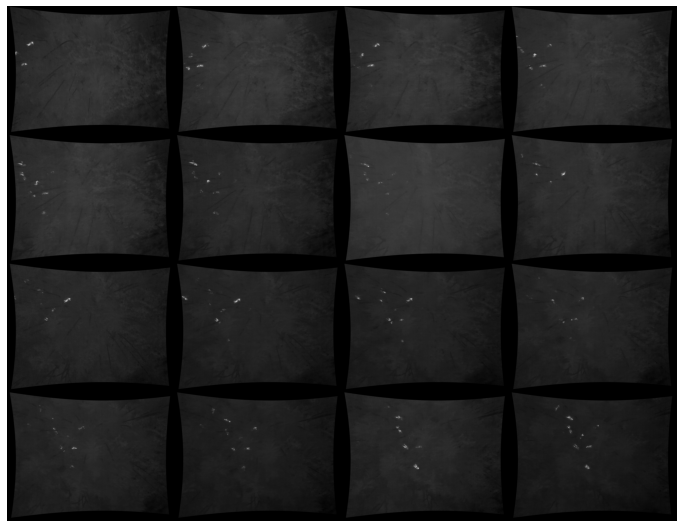

In [95]:
show_images(images[:16], figsize=(12, 12))

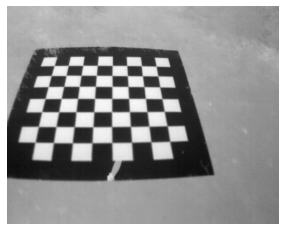

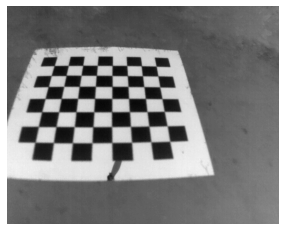

In [5]:
show_image(images[0], cmap='gray')  # original color
show_image(-images[0] + 255, cmap='gray')  # inverted color

In [6]:
# checkerboard is of grid type (8, 7), as a convention
# the longer side is considered the width of the board
grid = (8, 7)
square_size = 50  # mm

In [7]:
def search_for_corners(images, grid, invert=False) -> Tuple[np.array, np.ndarray]:
    found_corners = []
    mask = []
    for image in tqdm(images):
        if invert:
            image = -image + 255
        found, corners = cv2.findChessboardCorners(image, grid)
        mask.append(found)
        if found:  # refine corners on subpixel level
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners = cv2.cornerSubPix(image, corners, (11, 11), (-1, -1), criteria)
            found_corners.append(corners)
    return np.array(mask), np.array(found_corners)

In [8]:
mask, found_corners = search_for_corners(images, grid)

In [9]:
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

opencv checkerboards have to be $\textbf{white}$ along the borders!

In [10]:
mask, found_corners = search_for_corners(images, grid, invert=True)

In [11]:
mask

array([ True,  True,  True,  True, False, False, False,  True, False,
        True, False,  True, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
        True,  True, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False,  True])

In [12]:
f'{mask.sum()}/{len(mask)}'

'17/43'

In [13]:
def draw_corners(image, corners, grid, cmap=None):
    image = cv2.drawChessboardCorners(image[..., None].repeat(3, axis=-1), grid, corners, True)
    show_image(image, cmap=cmap)

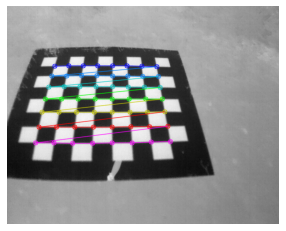

In [14]:
draw_corners(images[mask, ...][0], found_corners[0], grid)

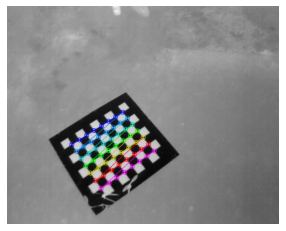

In [15]:
draw_corners(images[mask, ...][3], found_corners[3], grid)

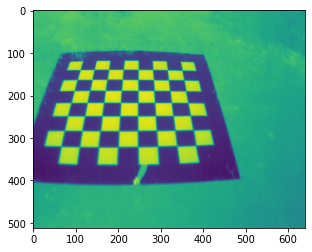

In [16]:
plt.imshow(images[mask, ...][0])
plt.show()

In [17]:
found_corners.shape

(17, 56, 1, 2)

In [18]:
# in the last dimension the points are given as: (ypos, xpos) 
found_corners[0][:10]  # visualize the first 10 points

array([[[111.69566, 140.55962]],

       [[144.65807, 140.15845]],

       [[178.95203, 139.92043]],

       [[213.11946, 140.02362]],

       [[248.26646, 140.24301]],

       [[282.41882, 140.4859 ]],

       [[316.77563, 140.91766]],

       [[351.58173, 141.93881]],

       [[104.68337, 163.95901]],

       [[139.65048, 163.51772]]], dtype=float32)

In [19]:
image_points = found_corners  # 2d points in image plane
# 3d point in real world space, z coordinates will stay 0
world_points = np.zeros((*found_corners.shape[:2], 3), 
    dtype=found_corners.dtype)
# create xy world points
xy = square_size * np.mgrid[:grid[0],:grid[1]].T.reshape(-1, 2)
world_points[..., :2] = xy

In [20]:
world_points[0][:10]

array([[  0.,   0.,   0.],
       [ 50.,   0.,   0.],
       [100.,   0.,   0.],
       [150.,   0.,   0.],
       [200.,   0.,   0.],
       [250.,   0.,   0.],
       [300.,   0.,   0.],
       [350.,   0.,   0.],
       [  0.,  50.,   0.],
       [ 50.,  50.,   0.]], dtype=float32)

In [21]:
image_shape = images.shape[-2:]
image_shape  # height, width

(512, 640)

In [22]:
err, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(world_points, 
    image_points, image_shape, None, None)

In [23]:
err  # overall RMS re-projection error

2.9483014665889633

In [24]:
K  # intrinsic camera matrix

array([[532.0650369 ,   0.        , 330.35678047],
       [  0.        , 531.0667174 , 239.67564551],
       [  0.        ,   0.        ,   1.        ]])

In [25]:
# contains coefficients for radial and tangential distortion
dist_coeffs

array([[-0.28356168,  0.12272386, -0.00055183,  0.00079745, -0.02986768]])

In [26]:
rvecs[0].shape

(3, 1)

A rotation matrix is an array of nine numbers. These are subject to the six norm and orthogonality constraints, so only three degrees of freedom are left: if $\textbf{three}$ of the numbers are given, the other six can be
computed from these equations.

The conversion from a rotation vector to a rotation matrix is called $\textbf{Rodrigues’ formula}$.

Euler’s theorem, stating that every rotation can be described by an axis of rotation and an angle around it. A $\textbf{compact representation}$ of axis and angle is a three-dimensional rotation vector whose direction is the axis and whose magnitude is the angle in radians and the axis is oriented so that the acute-angle rotation is counterclockwise around it.

In [27]:
tvecs[0].shape

(3, 1)

$\textbf{Rodrigues’ formula}$

$R = I \cos{\theta} + (1 - \cos{\theta}) uu^T + u_x \sin{\theta}$

if $r$ denotes the rotation vector s.t. $|r| \le \pi$ we get

$\theta = |r|$

$u = \frac{r}{\theta}$

$u_x = \left(\begin{array}{rrr} 
0 & -u_3 & u_2 \\ 
u_3 & 0 & -u_1 \\ 
-u_2 & u_1 & 0 \\ 
\end{array}\right)$

In [28]:
def rodrigues(rvecs: List[np.ndarray]) -> List[np.ndarray]:
    Rmats = []
    for r in rvecs:  # loop over rotation vectors
        if (r == np.zeros((3, 1))).all():
            R = np.eye(3)
            Rmats.append(R)
        else:
            theta = np.linalg.norm(r, axis=0).item()  # scalar
            u = r / theta  # column vector
            u_x = np.array([
                [0, -u[2, 0], u[1, 0]],
                [u[2, 0], 0, -u[0, 0]],
                [-u[1, 0], u[0, 0], 0]
            ])  # cross product matrix
            R = (np.eye(3) * np.cos(theta) + (1 - np.cos(theta)) * u @ u.T +
                u_x * np.sin(theta))  # rotation matrix
            Rmats.append(R)
    return Rmats

In [29]:
Rmats_v1 = [cv2.Rodrigues(r)[0] for r in rvecs]
Rmats_v1[0]

array([[ 0.9887738 ,  0.09668017, -0.11392681],
       [-0.00193055,  0.770662  ,  0.63724121],
       [ 0.14940765, -0.62986747,  0.76219704]])

In [30]:
Rmats_v2 = rodrigues(rvecs)
Rmats_v2[0]

array([[ 0.9887738 ,  0.09668017, -0.11392681],
       [-0.00193055,  0.770662  ,  0.63724121],
       [ 0.14940765, -0.62986747,  0.76219704]])

In [31]:
np.isclose(Rmats_v1, Rmats_v2).all()

True

In [32]:
Rmats = Rmats_v1

### read data

(512, 640)


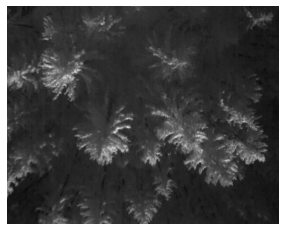

In [33]:
path = '../data/F0/Images/1/20191004_091801.tiff'
img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)  # can read 16 and 32 bit depth
print(img.shape)
# we read 16 bit gray scale (single channel) images
img = cv2.normalize(img, dst=None, alpha=0, beta=2**16 - 1, norm_type=cv2.NORM_MINMAX)
show_image(img, cmap='gray')

In [34]:
path = '../data/F0/Labels/Label1.json'
label = json.load(open(path, 'rb'))
label  # only a single image was anotated here

{'Labels': [{'class': 0,
   'poly': [[295.2722994930608, 127.84750396590255],
    [270.79935814945384, 127.84750396590255],
    [270.79935814945384, 148.58431658992635],
    [295.2722994930608, 148.58431658992635]],
   'imagefile': '20191004_091820.tiff'},
  {'class': 0,
   'poly': [[376.3033127952515, 195.83085348853353],
    [356.3986404414204, 195.83085348853353],
    [356.3986404414204, 223.1975489852984],
    [376.3033127952515, 223.1975489852984]],
   'imagefile': '20191004_091820.tiff'},
  {'class': 0,
   'poly': [[374.09522956108435, 115.94376329999017],
    [354.1905572072533, 115.94376329999017],
    [354.1905572072533, 143.31045879675503],
    [374.09522956108435, 143.31045879675503]],
   'imagefile': '20191004_091820.tiff'}]}

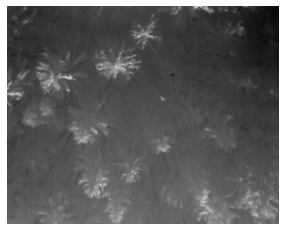

(512, 640, 3) uint8
(3, 4, 2)


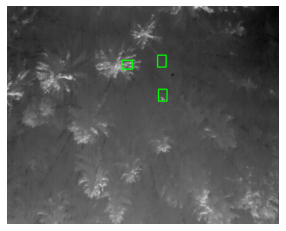

In [35]:
# lets check that images' content
path = '../data/F0/Images/1/20191004_091820.tiff'
img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)  # can read 16 and 32 bit depth
# we read 16 bit gray scale (single channel) images
img = cv2.normalize(img, dst=None, alpha=0, beta=2**16 - 1, norm_type=cv2.NORM_MINMAX)
show_image(img, cmap='gray')

# extract poly annotations from json
polys = []
for item in label['Labels']:  # list of dictionaries
    polys.append(item['poly'])
    
# draw annotation on top
img = (img >> 8).astype(np.uint8)  # 8 bit image
img = img[..., None].repeat(3, axis=-1)  # rgb image
print(img.shape, img.dtype)
polys = np.array(polys, dtype=np.int32)
print(polys.shape)
img = cv2.polylines(img, polys, isClosed=True, color=(0, 255, 0), thickness=2)
show_image(img)

In [36]:
path = '../data/F0/Poses/1.json'
pose = json.load(open(path, 'rb'))
pose  # poses are ordered like image files of a lane

{'images': [{'imagefile': '20191004_091801.tiff',
   'M3x4': [[0.547685385, -0.833771348, 0.0697564855, 15.0560455],
    [0.820245326, 0.518609703, -0.241332591, 5.25090075],
    [0.165039837, 0.189391777, 0.967932105, 27.4987831]]},
  {'imagefile': '20191004_091802.tiff',
   'M3x4': [[0.560714066, -0.825065851, 0.0697564557, 15.0050125],
    [0.811998367, 0.531429529, -0.241332605, 4.01245594],
    [0.162044659, 0.191960722, 0.967932045, 27.3486519]]},
  {'imagefile': '20191004_091803.tiff',
   'M3x4': [[0.559273303, -0.826043189, 0.0697564408, 14.7013063],
    [0.812924504, 0.530011594, -0.241332605, 3.15025258],
    [0.162379429, 0.19167763, 0.967932045, 27.3105373]]},
  {'imagefile': '20191004_091805.tiff',
   'M3x4': [[0.560714066, -0.825065851, 0.0697564557, 14.4744177],
    [0.811998367, 0.531429529, -0.241332605, 2.10313416],
    [0.162044659, 0.191960722, 0.967932045, 26.9624977]]},
  {'imagefile': '20191004_091806.tiff',
   'M3x4': [[0.573604524, -0.816156745, 0.0697564632, 1

to calculate a 2D image point from a 3D world point P we have to calculate:

$p = \frac{1}{z} M P$

### following the integral example from the exercise in matlab

In [37]:
# display multiple images of a line
files = glob('../data/F6/Images/4/*.tiff', recursive=False)
label = json.load(open('../data/F6/Labels/Label4.json', 'rb'))
pose = json.load(open('../data/F6/Poses/4.json', 'rb'))

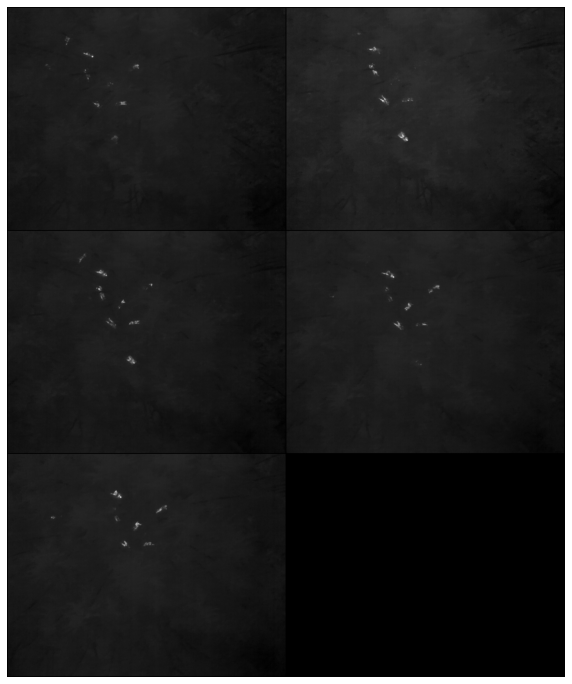

In [103]:
def imread(files: List[str], undistort=False):
    images = []
    for path in files:
        image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
        image = cv2.normalize(image, dst=None, alpha=0, beta=2**16 - 1, 
            norm_type=cv2.NORM_MINMAX)
        image = (image >> 8).astype(np.uint8)  # 8 bit image
        if undistort:  # undistort camera images
            h, w = image.shape
            # returns the new camera intrinsic matrix based 
            # on the free scaling parameter
            refined_K, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, 
                (w, h), 1, (w, h))
            x, y, w, h = roi
            image = image[y:y+h, x:x+w]
            image = cv2.undistort(image, K, dist_coeffs, None, refined_K)
        images.append(image)
    images = np.array(images)  # n x h x w
    return images
    

images = imread(files, undistort=False)
image_ids = list(range(13, 18))
show_images(images[image_ids], figsize=(10, 15))

In [104]:
M = []
for item in pose['images']:  # list of dictionaries
    M.append(np.array(item['M3x4']))
M = np.array(M)
M.shape

(29, 3, 4)

homogenous coordinates $p_i$ (2D image space) and P (3D world space)

$p_i := (u, v, 1)^T$

$P := (x, y, z, 1)^T$

$P_{xyz} := (x, y, z)^T$

$p_c = \frac{1}{z} M_c P$

$p_r = \frac{1}{z} M_r P$

$p_i = \frac{1}{z} K (R_i P_{xyz} + t_i)$

$P_{xyz} = R_r^{-1}(z K^{-1} p_r - t_r)$

rotation matrices are orthogonal

$R^{-1} = R^T$

with these equations we can write down the relation between an arbitrary point $p_r$ 
to another point $p_c$ in a different image space as  

$p_c = K R_c R_r^T K^{-1} p_r + \frac{1}{z} K (t_c - R_c R_r^T t_r)$

conveniently we can define relative rotation $R$ and translation $t$

$R = R_c R_r^T$

$t = \frac{1}{z} K (t_c - R_c R_r^T t_r)$

yielding

$p_c = K R K^{-1} p_r + \frac{1}{z} K t$

but for image warping we have to provide a matrix to transform from one space to the other thus
define $B := K R K^{-1}$ and denote the column vectors of $B$ as $b_i$ with $i \in {1, 2, 3}$ 

$p_c = B (u_r, v_r, 1)^T + \frac{1}{z} K t = b_1 u_r + b_2 v_r + (b_3 + \frac{1}{z} K t) 1$

we get $B^{'}$ by replacing $b_3 \rightarrow b_3 + \frac{1}{z} K t$ which leads to the final transformation

$p_c = B^{'} p_r$

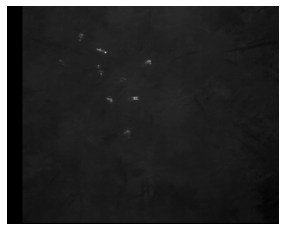

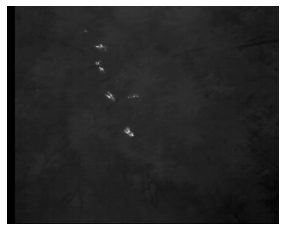

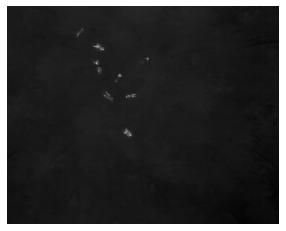

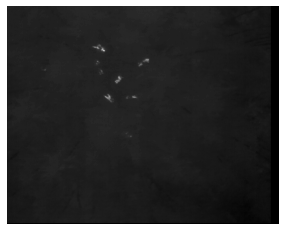

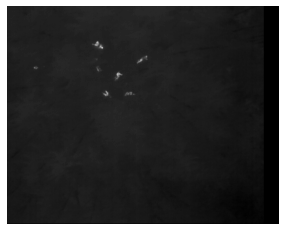

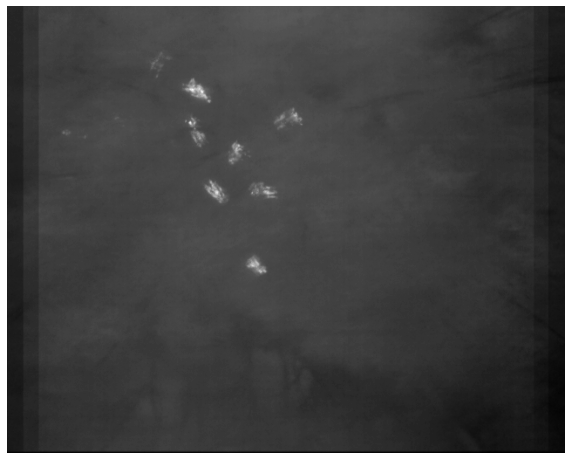

In [203]:
def integrate(images: np.ndarray, win: List[int], K: np.ndarray, 
    M: np.ndarray, z: float, verbose=False):
    """ win ... window of integration """
    h, w = images.shape[1:]  # gray scale images
    integral = np.zeros((h, w), np.float64)
    _images = images[win]
    _M = M[win]
    count = len(win)
    
    # center index
    idc = len(_images) // 2
    
    # invese of the intrinsic mapping
    K_inv = np.linalg.inv(K)
    
    # M = ( A b ) or M = K ( R t )
    Mc = _M[idc]  # 3 x 4

    # the given M matrices seem to consist solely of ( R t ) part
    Rc = Mc[:, :3]  # 3 x 3
    tc = Mc[:, 3:]  # 3 x 1

    for i in range(len(_images)):
        if i != idc:
            Mr = _M[i]  # 3 x 4
            Rr = Mr[:, :3]  # 3 x 3
            tr = Mr[:, 3:]  # 3 x 1

            # relative translation and rotation
            R_ = Rc @ Rr.T  # 3 x 3
            t_ = tc - R_ @ tr  # 3 x 1

            B = K @ R_ @ K_inv
            B[:, 2:] += K @ t_ / z
            warped = cv2.warpPerspective(_images[i], B, (w, h))
            if verbose:
                show_image(warped, cmap='gray')
            integral += warped
        else:
            if verbose:
                show_image(_images[i], cmap='gray')
            integral += _images[i]

    integral /= count
    integral = cv2.normalize(integral, None, 
        0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return integral  # 8bit gray scale integral image 


z = 30  # m
integral = integrate(images, image_ids, K, M, z, verbose=True)
show_image(integral, cmap='gray', figsize=(10, 15))

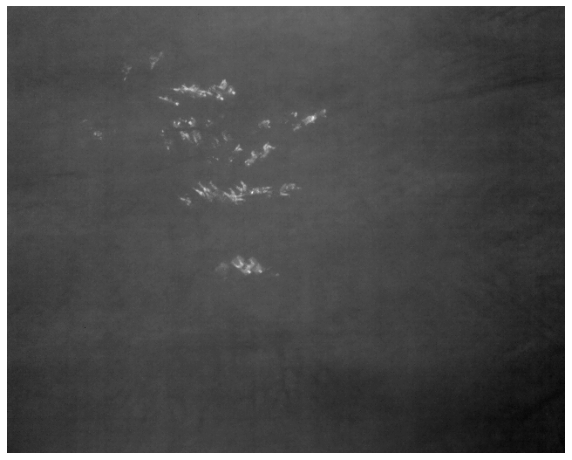

In [118]:
# contrary simply summing up images is insufficient
image_sum = images[image_ids].mean(axis=0)
show_image(image_sum, cmap='gray', figsize=(10, 15))

In [119]:
def find_file_index(name: str):
    """ return -1 if name not part of a file name"""
    for i, file in enumerate(files):
        if name in file:
            return i
    else:
        return -1

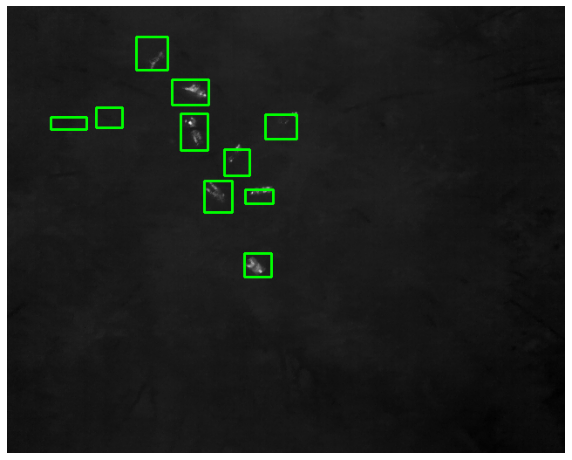

In [120]:
idx = find_file_index('20191108_104942.tiff')

# extract poly annotations from json
polys = []
for item in label['Labels']:  # list of dictionaries
    polys.append(item['poly'])


def annotate(image, polys, color=(0, 255, 0)):
    image = image[..., None].repeat(3, axis=-1)  # rgb image
    polys = np.array(polys, dtype=np.int32)
    image = cv2.polylines(image, polys, isClosed=True, 
        color=color, thickness=2)
    return image  # annotation drawn on top


# labels for the integral image shown at central image
show_image(annotate(images[idx], polys), figsize=(10, 15))

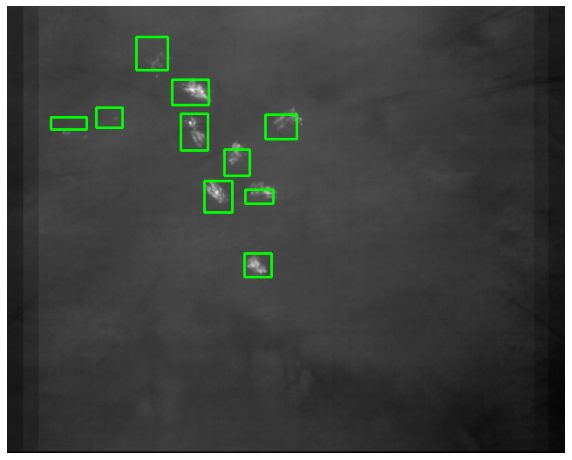

In [201]:
# integral image plus labels
show_image(annotate(integral, polys), figsize=(10, 15))

In [189]:
# bounding boxes are not always axis aligned
def aabb(polys: List[np.ndarray]) -> np.ndarray:
    bboxes = np.empty((len(polys), 4), dtype=np.float32)
    for i, poly in enumerate(polys):  # height, width
        # poly given as (x, y) points
        x = poly[:, 0]
        y = poly[:, 1]
        xmin, ymin = x.min(), y.min()
        xmax, ymax = x.max(), y.max()
        width = xmax - xmin
        height = ymax - ymin
        bboxes[i, :] = (xmin, ymin, width, height)
    return bboxes


def annotate_aabb(image, bboxes, color=(0, 255, 0)):
    image = image[..., None].repeat(3, axis=-1)  # rgb image
    for bbox in bboxes:
        image = cv2.rectangle(image, bbox, 
            color=color, thickness=2)
    return image  # annotation drawn on top

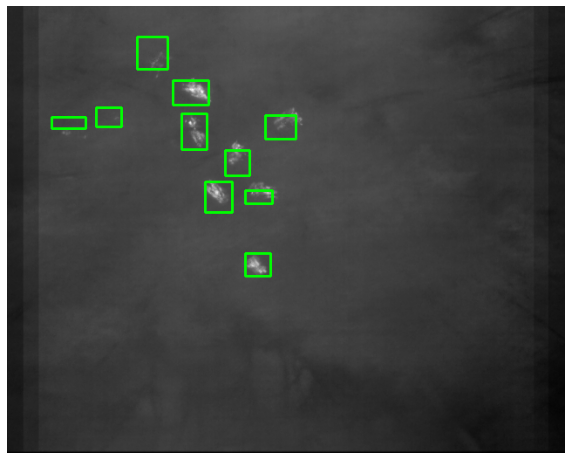

In [202]:
polys = [np.array(poly) for poly in polys]
bboxes = aabb(polys)

# here we already had AABB so nothing changed
show_image(annotate_aabb(integral, bboxes), figsize=(10, 15))

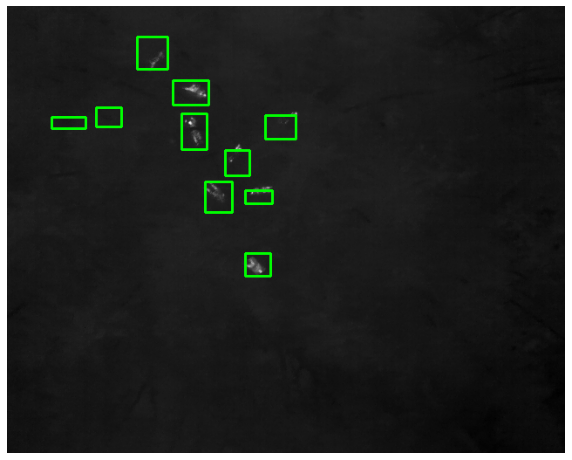

In [191]:
# here we already had AABB so nothing changed
show_image(annotate_aabb(images[idx], bboxes), figsize=(10, 15))

### pytorch approach

In [ ]:
tasks:
    model for data pre processing (instead of integral)
    thus use image sequences as input and single integral as target
    
    model for object localization -> get bboxes
    
    transform detections to COCO format for and official AP metric calculation